# Analysis of TSP Approximation Algorithms
## Introduction
The problem is often described as a salesman who would like to visit each city no more than once and return home. The journey to each city has a certain expense; the salesman would like to find the most optimal solution. This can be represented with edge weights between the vertices. So we want to find a route where the sum of the edge weights is the lowest possible value. Given a large set of cities (nodes) this has proven to be an intractable problem- it's NP-hard. 

Before getting into it, let's consider two other common paths that may traverse a graph. The first is an Eulerian circuit which touches every node in the graph and returns to the origin. The second is a Hamiltonian cycle which similar to the Eulerian cycle in that it must touch every node and return to the origin. However the Hamiltonian cycle mandates that each node is only visited once. This is quite similar to the traveling salesman problem, a reduction can be shown to prove that TSP is NP-hard without too much massaging. So once again, think of the Traveling Salesman Problem as finding the Hamiltonian cycle with the minimum possible weight.


It's important to note that the algorithms in question, and indeed the ones I intend to implement, are only approximations. Approximations appear to be the only way to solve inputs that are millions of cities large. They find solutions appromization ratios which may be considered "good enough". Good enough of course depends on the standard one chooses to hold, but algorithms of note seem to yield a solution which is 2-3% close to optimal.[1] One of the approximations will fail terribly, this is the nearest neighbor. Christofides actually does quite well, yielding the best approximation ratio of all known algorithms in the general case. The detached-stem method, also known as the Lin–Kernighan heuristic, will also be investigated. < TODO More here > 

// Theory of TSP and the like
Three assumptions for TSP
1) The distance between any two nodes is greater than or equal to zero d(x,y) >= 0
2) The graph is undirected d(x,y) = d(y,x) 
3) The triangle inequality exists: If a single edge reachs a point that two or more edges can reach together, the single edge is shorter than the sum of the other edges. d(x,y) + d(y,z) >= d(x,z)


// need test vectors

// nearest neighbor
// TODO write the shittiest algorithm and watch it suck

In [44]:
# This cell must be run before the other cells.
import networkx as nx
import random as rng
from networkx.drawing.nx_pydot import write_dot

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

Number of nodes in small graph: 6


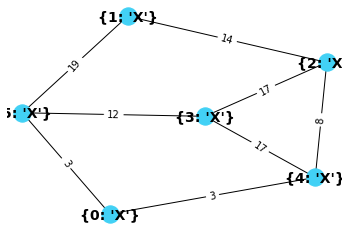

In [676]:
###############################
#     SMALL VISUAL GRAPH      #
###############################
sm_num_of_nodes = 6 # rng.randrange(5,10)
max_edge_weight = 20
prob_of_edge_creation = 0.5

print("Number of nodes in small graph: {}".format(sm_num_of_nodes))
sm_graph = nx.fast_gnp_random_graph(sm_num_of_nodes, prob_of_edge_creation, None, False)

# only works on connected graphs.
while not nx.is_connected(sm_graph):
    sm_graph = nx.fast_gnp_random_graph(sm_num_of_nodes, prob_of_edge_creation, None, False)

# for each node in the small graph, initialize it to unvisited
fresh_node_labels = [{'visited': 'X', 'origin': False}] # if this .--  is not a dictionary then it's applied to all nodes
nx.set_node_attributes(sm_graph, fresh_node_labels, 'node-label')

# for each node in the small graph, assign a random weight
for (u, v) in sm_graph.edges():
    sm_graph.edges[u,v]['weight'] = rng.randint(1, max_edge_weight)
    
# add edges to the small graph that is printable
pos = nx.nx_agraph.graphviz_layout(sm_graph)
edge_labels = nx.get_edge_attributes(sm_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(sm_graph, pos, edge_labels=edge_labels)

# need to remove the origin attribute being passed to `draw` to keep it clean
node_labels = nx.get_node_attributes(sm_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}

# Draw the graph below
nx.draw(sm_graph, pos=pos, labels=print_node_labels, node_color='#42d1f5', font_size=14, font_weight='bold')


####### Large graph stuff #######
# for each node in the large graph, assign a random weight
# lg_num_of_nodes = rng.randrange(40, 60) # the other is `lg` which is a large graph output to a file.
# lg_graph = nx.fast_gnp_random_graph(lg_num_of_nodes, prob_of_edge_creation, None, False)
# print("Number of nodes in large graph: {}".format(lg_num_of_nodes))

# for (u, v) in lg_graph.edges():
#     lg_graph.edges[u,v]['weight'] = rng.randint(0, max_edge_weight)

# # write the dot file TODO: maybe write edges
# write_dot(lg_graph, 'file.dot')
# print("Dot file written")
# ! dot -Tpng file.dot -o file.png  # add -v for verbose output
# print("Dot to png conversion complete")
# ! chmod 777 file.png # wide open permissions until this is constrained

# print("\nThis is a graph before finding an optimal path.")

In [677]:
###############################
#     SMALL VISUAL GRAPH      #
###############################
verbose = True
output_graph = nx.create_empty_copy(sm_graph,with_data=False)

# At the beginning, all nodes are unvisited and marked with 'X'
# origin is the current_node to start
current_node = rng.randrange(0, sm_num_of_nodes)

print("origin " + str(current_node))

# A list of attempted origins in case the origin doesn't work out.
attempted_origins = list(range(sm_num_of_nodes))
attempted_origins.pop(current_node)
print("Attempted origins: ", end='')
print(attempted_origins)

next_node = None
next_node_edge = None  # TODO: accumulate edge weight
total_path_weight = 0
is_ham_circuit = False

# set origin to true by accessing that particular node and updating it's attribute by sending in a new dict
nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})


while True:
    
    # flag to show if further travel is possible
    neighbor_exists = False
    
    # reset the highest possible weight
    lowest_weight_edge = max_edge_weight + 1

    # all nodes that share an edge incident to current_node
    neighbors = [n for n in sm_graph.neighbors(current_node)]
    
    if verbose:
        print("The lowest weight edge is " + str(lowest_weight_edge))
        print("Next node is " + str(next_node))
    
    for node in neighbors:

        # has the neighbor node been visited
        not_visited = sm_graph.nodes[node]['node-label'][0]['visited'] != 'o'
        if verbose:
            print("The node has not been visited " + str(not_visited))
            
        # weight of the edge to the neighbor node
        edge_weight_to_neighbor = sm_graph.get_edge_data(current_node, node)['weight']
        if verbose:
            print("The edge weight to this neighbor is " + str(edge_weight_to_neighbor))
        
        # is neighbor node the origin
        is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
        if verbose:
            print("Is it the origin " + str(is_origin))
        
        # if the node hasn't been visited and the edge between this and that is current minimum and it ain't the origin
        if not_visited and edge_weight_to_neighbor < lowest_weight_edge and not is_origin:
            # this is now the edge lowest weight edge leaving `u`
            lowest_weight_edge = edge_weight_to_neighbor
            next_node = node
            neighbor_exists = True # need to know if we should try and return to origin
            
    # then we have to attempt to get back to the origin, need to iterate once more. we couldn't have taken this edge before
    if not neighbor_exists:
        print("Perhaps we've finished. Attempting to find the origin.")
        for node in neighbors:
            is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
#             print("It's defintely the origin right?" + str(is_origin))
            if is_origin:
                print("Found the origin.")
                # simply add that edge weight and return
                next_edge_weight = sm_graph.get_edge_data(current_node, node)['weight']
                print("node " + str(node))
                print("current_node " + str(current_node))
                print("next edge weight " + str(next_edge_weight))
                output_graph.add_edge(current_node, node, weight=next_edge_weight)
                total_path_weight += next_edge_weight
                
                if nx.is_connected(output_graph): # then we know we're good. Probably an O(nlogn) DFS
                    is_ham_circuit = True
                    break
        if is_ham_circuit:
            break
        else:
            try:
                if is_origin and not is_ham_circuit:
                    print("We found the origin, but no ham cycle. Choosing a new origin.")
                else:
                    print("We found the origin, but no ham cycle. Choosing a new origin.")
                # try different origins till exhaustion
                print("About to remove this from attempt_origins " + str(current_node))
                attempted_origins.remove(current_node)
                current_node = attempted_origins[0]
                print(attempted_origins)
                print("Trying a different origin: " + str(current_node))
                
                # refresh the 'visited' attribute of the previously visited nodes, assign origin
                node_labels = [{'visited': 'X', 'origin': False}] 
                nx.set_node_attributes(sm_graph, node_labels, 'node-label')
                nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})
                
                # clone the old graph after it's been reset
                output_graph = nx.create_empty_copy(sm_graph,with_data=False)
                
                # reset all of the flags
                total_path_weight = 0
                neighbor_exists = False
                next_node = None
                continue
            except (ValueError):
                print("Unable to find a Hamiltonian circuit for our salesperson.")
                raise StopExecution
                # clear the graph and try again with all other points except this one.
    
    if verbose:
        print("The current node is " + str(current_node))
        print("The next node is " + str(next_node))
    next_edge_weight = sm_graph.get_edge_data(current_node, next_node)['weight']
    output_graph.add_edge(current_node, next_node, weight=next_edge_weight)
    total_path_weight += next_edge_weight
    
    current_node = next_node 
    
    if verbose:
        print("The node's new node label is " + str(sm_graph.nodes[current_node]['node-label']))
        print("Total path weight " + str(total_path_weight))
        print("----\n")
        print(sm_graph.nodes.data())
        print("----\n")
    
    # update the visited node    
    nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': False}]}})

print("Best route nearest neighbor could find: " + str(total_path_weight))
# drawing stuff
node_labels = nx.get_node_attributes(sm_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}
pos = nx.nx_agraph.graphviz_layout(sm_graph)
edge_labels = nx.get_edge_attributes(output_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(output_graph, pos, edge_labels=edge_labels)
nx.draw(output_graph, pos=pos, labels=print_node_labels, node_color='#42d1f5', font_size=14, font_weight='bold')

origin 5
Attempted origins: [0, 1, 2, 3, 4]
The lowest weight edge is 21
Next node is None
The node has not been visited True
The edge weight to this neighbor is 3
Is it the origin False
The node has not been visited True
The edge weight to this neighbor is 19
Is it the origin False
The node has not been visited True
The edge weight to this neighbor is 12
Is it the origin False
The current node is 5
The next node is 0
The node's new node label is [{'visited': 'X', 'origin': False}]
Total path weight 3
----

[(0, {'node-label': [{'visited': 'X', 'origin': False}]}), (1, {'node-label': [{'visited': 'X', 'origin': False}]}), (2, {'node-label': [{'visited': 'X', 'origin': False}]}), (3, {'node-label': [{'visited': 'X', 'origin': False}]}), (4, {'node-label': [{'visited': 'X', 'origin': False}]}), (5, {'node-label': [{'visited': 'o', 'origin': True}]})]
----

The lowest weight edge is 21
Next node is 0
The node has not been visited True
The edge weight to this neighbor is 3
Is it the origin

An interesting thing to note about nearest neighbor is we'd technically always choose the lowest edge to ALL points in the graph. However, no node could exist two edges away and have a lesser weight then if we'd go through the intermediate note. With the assumption that there are no negative weights, that is.

THE ALGORITHM CAN FAIL! When that happens we simply choose another node in the set. that is why there is n^2 running time, we may need to try all possible paths.

DO THE OTHER ALGORITHMS DEPEND ON TRIANGLE INEQUALITY

Wikipedia psuedocode 
 * Initialize all vertices as unvisited.
 * Select an arbitrary vertex, set it as the current vertex u. Mark u as visited.
 * Find out the shortest edge connecting the current vertex u and an unvisited vertex v.
 * Set v as the current vertex u. Mark v as visited.
 * If all the vertices in the domain are visited, then terminate. Else, go to step 3.

Number of nodes in large graph: 6


TypeError: string indices must be integers

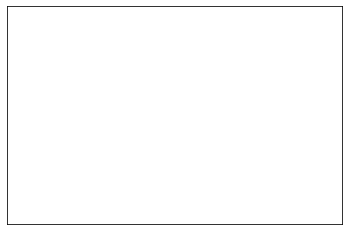

In [547]:
###############################
#     LARGE VISUAL GRAPH      #
###############################
lg_num_of_nodes = rng.randrange(5, 8)
max_edge_weight = 20
prob_of_edge_creation = 1.0

print("Number of nodes in large graph: {}".format(lg_num_of_nodes))

lg_graph = nx.fast_gnp_random_graph(lg_num_of_nodes, prob_of_edge_creation, None, False)
output_graph = nx.create_empty_copy(lg_graph,with_data=False)

# for each node in the large graph, initialize it to unvisited
node_labels = ['X'] 
nx.set_node_attributes(lg_graph, node_labels, 'node-label')

# for each node in the small graph, assign a random weight
for (u, v) in lg_graph.edges():
    lg_graph.edges[u,v]['weight'] = rng.randint(1, max_edge_weight)
    
# add edges to the small graph that is printable
pos = nx.nx_agraph.graphviz_layout(lg_graph)
edge_labels = nx.get_edge_attributes(lg_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(lg_graph, pos, edge_labels=edge_labels)

# need to remove the origin attribute being passed to `draw` to keep it clean ? Do I need this stuff with graphviz?
node_labels = nx.get_node_attributes(lg_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}

write_dot(lg_graph, 'file43.dot')
print("Dot file written")
! dot -Tpng file43.dot -o file43.png  # add -v for verbose output
print("Dot to png conversion complete")
! chmod 777 file43.png # wide open permissions until this is constrained
print("\nThis is a graph before finding an optimal path.")

![dotimage](./file43.png)
// begin with christofides

// the third one
    // ejection chains

// comparison of the three

// results

// conclusion

document references
https://www.sciencedirect.com/science/article/pii/S0377221710006065?via%3Dihub

programming resources
https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell/48000614

In [174]:
d = {1: {'weight': 8}, 2: {'weight': 14}, 13: {'weight': 1}}
lowest = 15
for e,k in d.items():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-174-72c738394b5c>, line 4)

In [175]:
# helper stuff

# this is how you access a particular node

# this is how you change a node's attribute
change_label = {7:'visited'}
nx.set_node_attributes(sm_graph, change_label, 'node-label')
print(sm_graph.nodes[7])

# random
1 in G     # check if node in graph

[n for n in G if n != None]  # iterate through nodes

len(G)  # number of nodes in graph

# traverse via edges
for u, v, weight in G.edges.data('weight'):
    if weight is not None:
        # Do something useful with the edges
        pass
    
G[<some-node>] # same as G.adj, this returns a dict of all the neighbor nodes

# print all of the neighbors of a node
for n in sm_graph.neighbors(7):
    print(n)
    
# or do this for list comprehension
[n for n in sm_graph.neighbors(7)]

# accessing an individual node attribute i.e. visited or unvisited
sm_graph.nodes[7]['node-label']

# part of me wants to update the node attributes like this
nx.set_node_attributes(G, {1:{'weight':-1, 'volume':4}})
G.nodes[1]['weight']
# or this
g.nodes['node1'].update(optional_attrs)  
# but what I really need to do is not have that attribute in list of edge weight/ neighbor node attributes


# getting an edge
G.edges([0, ])  # only edges incident to these nodes

{'node-label': 'visited'}
1
2
13


'visited'